# Imports

In [21]:
import torch
import pyro
import numpy as np
from matplotlib import pyplot as plt

# Problem statement

A simple problem where we try to map a mixture of Gaussians

In [2]:
D = 2  # Visualization won't work if you change this

In [11]:
points_per_gaussian = []
N = 200
G = 2
for i in range(G):
    L = -0.5 + torch.rand((D, D))
    gaussian = pyro.distributions.MultivariateNormal(
        loc=5 * torch.rand((D,)),
        covariance_matrix=L @ L.T
    )

    points_per_gaussian.append(gaussian.sample((N,)))


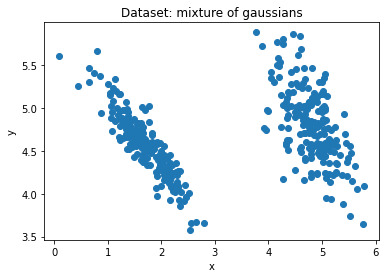

In [12]:
points = torch.cat(points_per_gaussian)
plt.scatter(
    points[:, 0],
    points[:, 1]
)
plt.title("Dataset: mixture of gaussians")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# NF construction

We start off with a simple normal distribution of the same dimensionality:

In [55]:
base_distribution = pyro.distributions.MultivariateNormal(
    loc=torch.zeros((D,)),
    covariance_matrix=torch.eye(D)
)

We are going to stack a few affine autoregressive blocks (MAF architecture)

In [56]:
n_blocks = 3
blocks = []
for _ in range(n_blocks):
    blocks.append(
        pyro.distributions.transforms.affine_autoregressive(
            input_dim=D,
            hidden_dims=[8, 8, 8]
        )
    )

We obtain a transformed distribution that can be used as any off-the-shelf distribution

In [57]:
transformed_distribution = pyro.distributions.TransformedDistribution(
    base_distribution=base_distribution,
    transforms=blocks
)

In [58]:
transformed_distribution.sample((2,))

tensor([[-0.6635, -0.8973],
        [ 1.1644,  0.6975]])

In [59]:
transformed_distribution.log_prob(torch.zeros((D,)))

tensor(-2.6708, grad_fn=<AddBackward0>)

# NF training

In [60]:
modules = torch.nn.ModuleList(blocks)
optimizer = torch.optim.Adam(modules.parameters())
n_epochs = 3000
epoch_visualization = 100

Epoch 100 / 3000 loss: 5.690152645111084


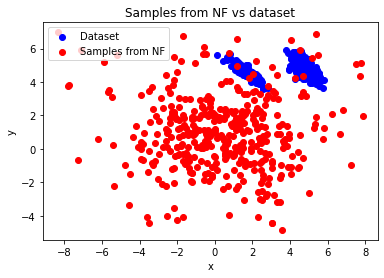

Epoch 200 / 3000 loss: 4.589250564575195


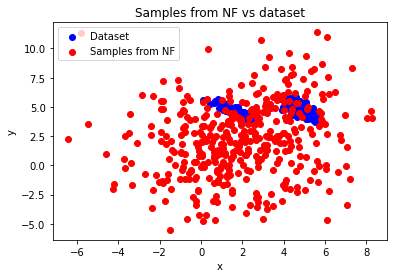

Epoch 300 / 3000 loss: 2.707352876663208


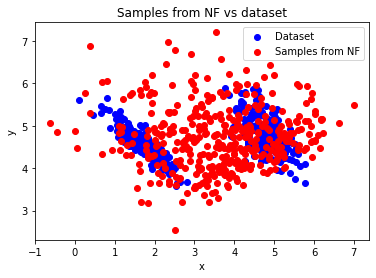

Epoch 400 / 3000 loss: 2.5082006454467773


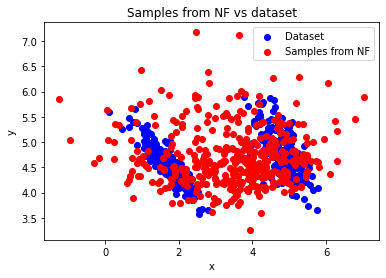

Epoch 500 / 3000 loss: 2.3538615703582764


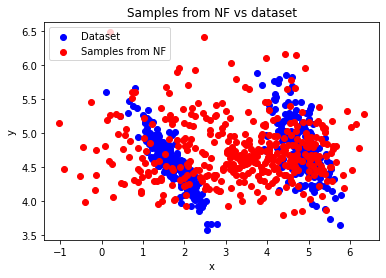

Epoch 600 / 3000 loss: 2.104478120803833


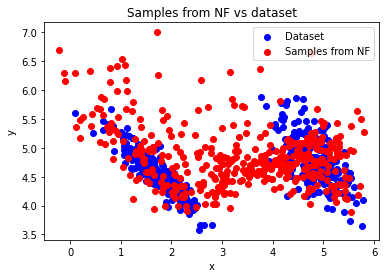

Epoch 700 / 3000 loss: 1.8180984258651733


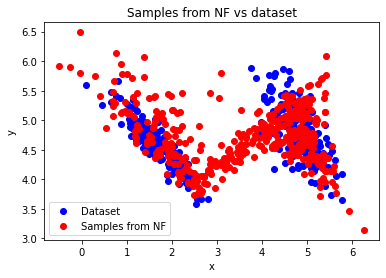

Epoch 800 / 3000 loss: 1.6301347017288208


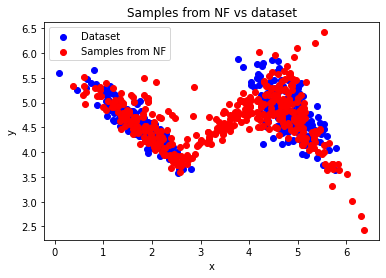

Epoch 900 / 3000 loss: 1.553910255432129


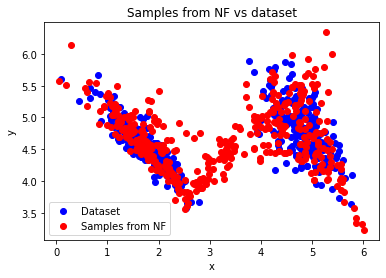

Epoch 1000 / 3000 loss: 1.4975554943084717


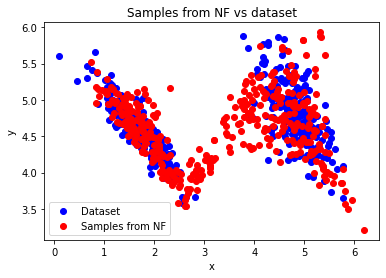

Epoch 1100 / 3000 loss: 1.4607914686203003


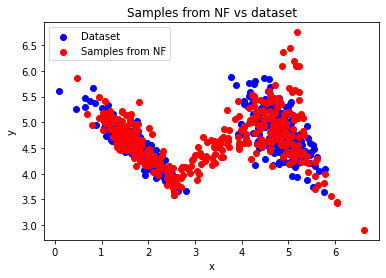

Epoch 1200 / 3000 loss: 1.4306048154830933


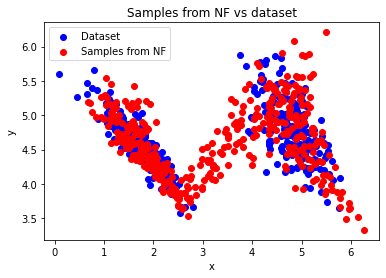

Epoch 1300 / 3000 loss: 1.3990496397018433


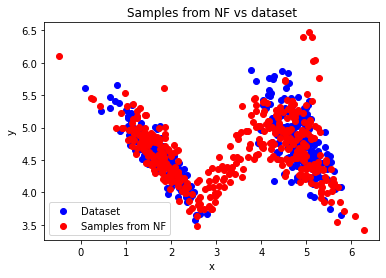

Epoch 1400 / 3000 loss: 1.374893307685852


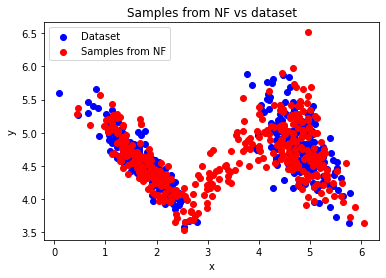

Epoch 1500 / 3000 loss: 1.3597619533538818


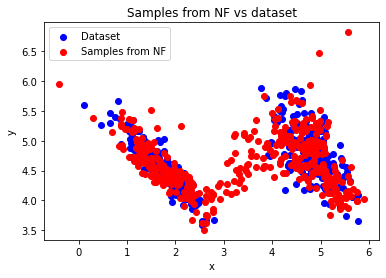

Epoch 1600 / 3000 loss: 1.3466861248016357


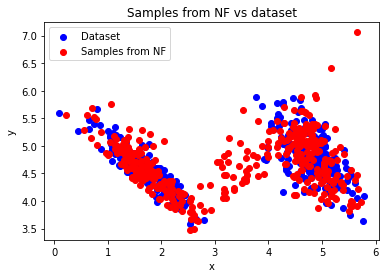

Epoch 1700 / 3000 loss: 1.3387842178344727


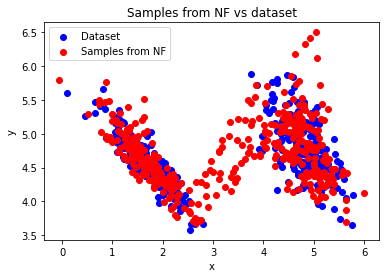

Epoch 1800 / 3000 loss: 1.3282861709594727


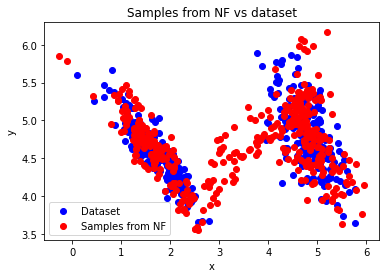

Epoch 1900 / 3000 loss: 1.3213589191436768


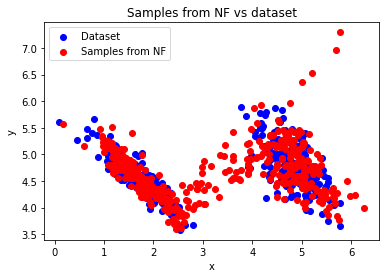

Epoch 2000 / 3000 loss: 1.3134554624557495


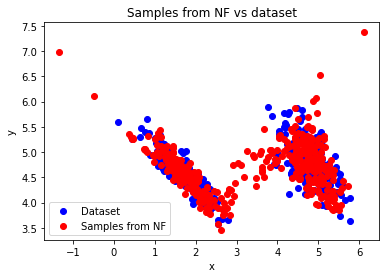

Epoch 2100 / 3000 loss: 1.2994166612625122


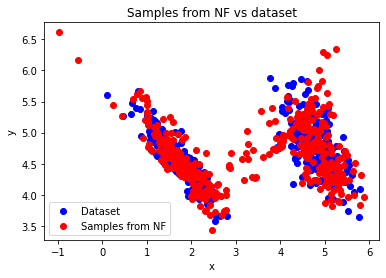

Epoch 2200 / 3000 loss: 1.297105073928833


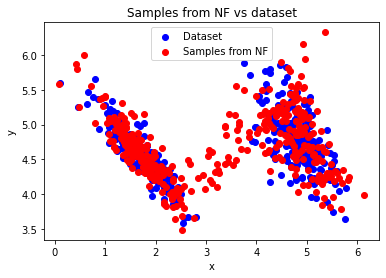

Epoch 2300 / 3000 loss: 1.2820872068405151


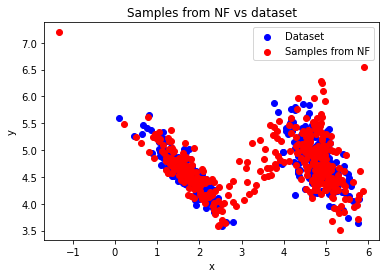

Epoch 2400 / 3000 loss: 1.2772959470748901


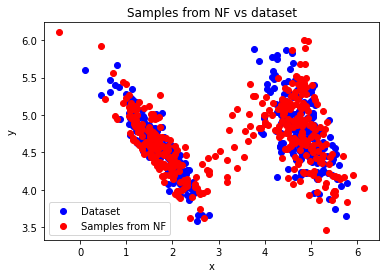

Epoch 2500 / 3000 loss: 1.270897388458252


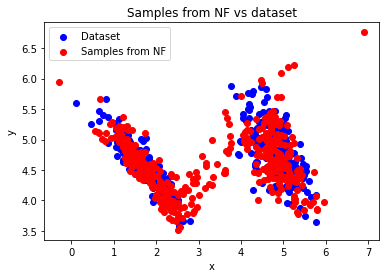

Epoch 2600 / 3000 loss: 1.2653985023498535


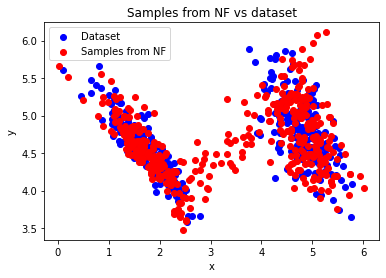

Epoch 2700 / 3000 loss: 1.2613251209259033


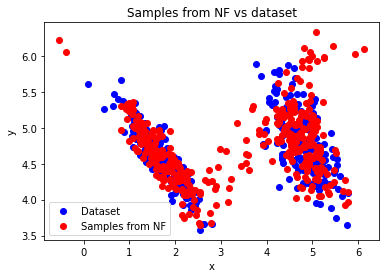

Epoch 2800 / 3000 loss: 1.2587199211120605


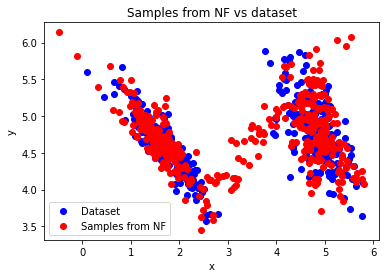

Epoch 2900 / 3000 loss: 1.2551422119140625


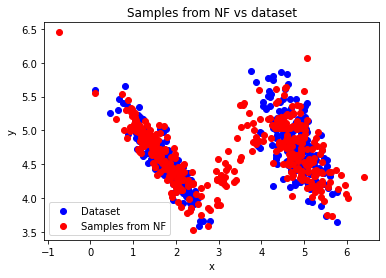

Epoch 3000 / 3000 loss: 1.2575262784957886


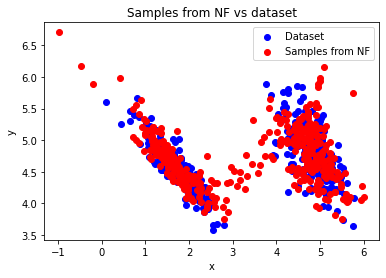

In [62]:
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    # batch gradient descent:
    loss = - transformed_distribution.log_prob(points).mean()
    loss.backward()
    optimizer.step()

    transformed_distribution.clear_cache()  # !! Important implementation detail

    if epoch % epoch_visualization == 0:
        samples = transformed_distribution.sample((2 * N,))
        print(f"Epoch {epoch} / {n_epochs} loss: {loss}")
        plt.scatter(
            points[:, 0],
            points[:, 1],
            color="blue"
        )
        plt.scatter(
            samples[:, 0],
            samples[:, 1],
            color="red"
        )
        plt.title("Samples from NF vs dataset")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(
            [
                "Dataset",
                "Samples from NF"
            ]
        )
        plt.show()

# Evaluation and visualization

We want to get a quiver representation of the transformation applied: we start off from a large mesh in the latent space of the base distribution:

In [108]:
X, Y = np.meshgrid(np.arange(-10, 10, 1), np.arange(-10, 10, 1))

In [109]:
X_Y_base = torch.stack(
    [
        torch.Tensor(X),
        torch.Tensor(Y)
    ],
    dim=-1
)

Each point in the grid gets transformed successively by each one of the blocks:

In [110]:
X_Y_transformed = X_Y_base
for block in blocks:
    X_Y_transformed = block(X_Y_transformed)

In [111]:
X_t, Y_t = X_Y_transformed[:, :, 0].detach(), X_Y_transformed[:, :, 1].detach()

To obtain the change in volume, we can compare the log_prob of the base and transformed distributions:

In [112]:
log_det_Js = transformed_distribution.log_prob(X_Y_transformed) - base_distribution.log_prob(X_Y_base)

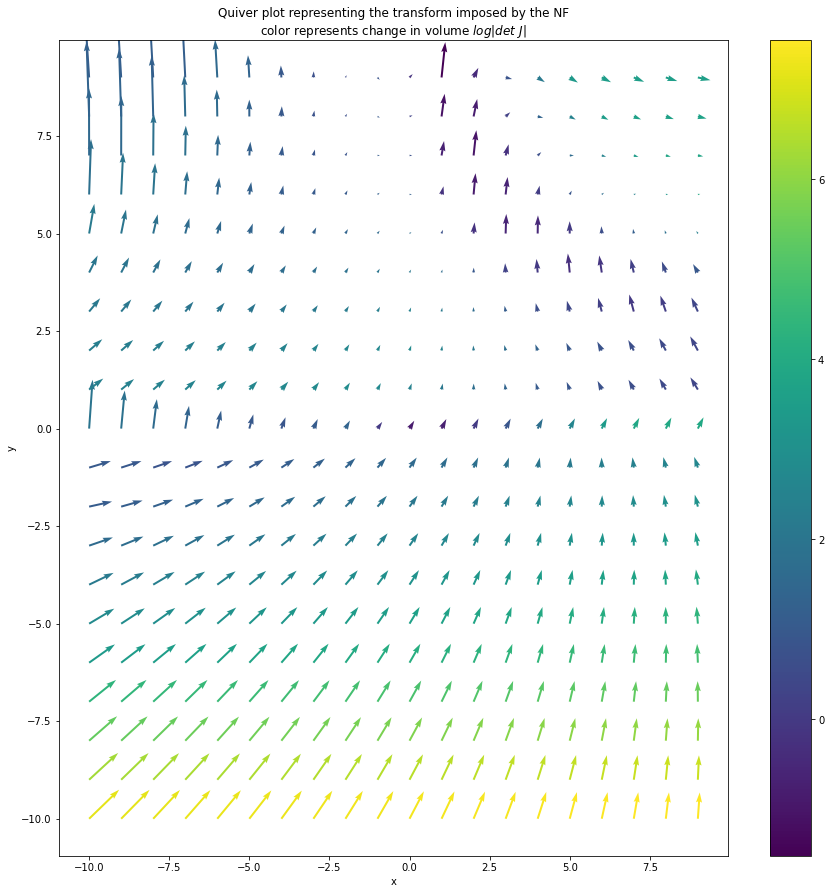

In [113]:
plt.figure(figsize=(15,15))
plt.quiver(
    X, Y, X_t - X, Y_t - Y, log_det_Js.detach(),
    angles="xy",
    units="xy"
)
plt.title("Quiver plot representing the transform imposed by the NF\ncolor represents change in volume $log|det\ J|$")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()